In [1]:
import pandas

print("Importing categorized names... ")
names = pandas.read_csv("data/names_cat.csv", usecols=["name", "n_publs", "likely_gender", "score"])
print("Names imported.")

Importing categorized names... 
Names imported.


In [2]:
# Setting index & accessing cells: https://pythonhow.com/accessing-dataframe-columns-rows-and-cells/
names = names.set_index("name", drop = False)
print(names[:10])

                                        name  n_publs likely_gender  score
name                                                                      
'Maseka Lesaoana            'Maseka Lesaoana        2        female      8
(David) Jing Dai            (David) Jing Dai        1          male      7
(Max) Zong-Ming Cheng  (Max) Zong-Ming Cheng        2          male      2
(Sophy) Shu-Jiun Chen  (Sophy) Shu-Jiun Chen        2        female      7
(Zhou) Bryan Bai            (Zhou) Bryan Bai        2          male      6
A Clara Kanmani              A Clara Kanmani        1        female      4
A Lun                                  A Lun        1          male      1
A Min Tjoa                        A Min Tjoa      211          male      2
A S Akshaya                      A S Akshaya        1          male      2
A'ang Subiyakto              A'ang Subiyakto        2        female      0


In [ ]:
# Get first name and last name from full name with NamSor
# Calculate the gender + score for the full name for those names with a score less than 7
# Save the new result (gender and score) in the df
# Compare the results. 
# To test if this makes sense: 
# Get sample of names with score less than 7
# send to api
# save results
# row: gender changed?: bool
# how much score changed?: int
# plot

In [3]:
print("Getting private key... ")
# Get private API Key for NamSor API v2 (contained in txt file)
key = ''

# Import personal key
with open("key.txt", "r") as file:
    key = file.read()

if(len(key) > 0):
    print("Got private key.")
else: 
    print("Could not find private key. Please check the file name and make sure you have an API key.")

Getting private key... 
Got private key.


In [4]:
# Setting up NamSor API v2 to get the gender of a name
# https://www.namsor.com/
# https://v2.namsor.com/NamSorAPIv2/apidoc.html
# using NamSor API v2 Python SDK
# https://github.com/namsor/namsor-python-sdk2
# licensed under GNU Affero General Public License v3.0

# Following script partly taken from https://github.com/namsor/namsor-python-sdk2 "Getting Started" 
# and adapted to keep key private and remove unnecessary lines.

print("Setting up NamSor API v2 connection settings...")

import openapi_client
from openapi_client.rest import ApiException

# Configure API key authorization: api_key
configuration = openapi_client.Configuration()
configuration.api_key['X-API-KEY'] = key
# create an instance of the API class
pers_api_instance = openapi_client.PersonalApi(openapi_client.ApiClient(configuration))

Setting up NamSor API v2 connection settings...


In [5]:
names_to_consider = names[names['score'] <= 3].sample(1000)
print("Will be parsing and reconsidering {} names.".format(len(names_to_consider)))

Will be parsing and reconsidering 1000 names.


In [6]:
# clean up names
# Strip numbers from a string: https://stackoverflow.com/questions/16849109/strip-out-numbers-from-a-string
# Remove white space at end from string: https://stackoverflow.com/questions/2372573/how-do-i-remove-whitespace-from-the-end-of-a-string-in-python
import re

def clean(x):
    return pandas.Series([x, re.sub(r'\d+','',x).rstrip()], index=['name', 'clean_name'])
                         
cleaned_names = names_to_consider['name'].apply(clean)
cleaned_names = cleaned_names.set_index('name')

names_to_consider=names_to_consider.merge(cleaned_names, how='left', left_index=True, right_index=True)

In [7]:
names_to_consider[:10]

,name,n_publs,likely_gender,score,clean_name
name,,,,,
Masayoshi Takeuchi,Masayoshi Takeuchi,1,male,3,Masayoshi Takeuchi
Natsuko Miki,Natsuko Miki,1,female,2,Natsuko Miki
Cheol-seung Lee,Cheol-seung Lee,1,male,2,Cheol-seung Lee
Aphra Shemza,Aphra Shemza,3,female,1,Aphra Shemza
Rui Belfort,Rui Belfort,1,male,3,Rui Belfort
Motti Neiger,Motti Neiger,1,male,2,Motti Neiger
Baozhu Zhao,Baozhu Zhao,2,male,2,Baozhu Zhao
Zhao-ling Tao,Zhao-ling Tao,1,male,2,Zhao-ling Tao
Zhenbo Wang,Zhenbo Wang,31,male,3,Zhenbo Wang


In [15]:
# Formatting the names using the API's models
def createPersonalNameIn(name_entry):
    return openapi_client.PersonalNameIn(id=name_entry['name'], name=name_entry['clean_name'])

In [67]:
# Now parsing the full names into first and last name, sending in
# one batch at a time and saving the result answer by answer.
# If the API calling gets interrupted:
# 1. check that no names got lost: ((len(names_to_consider)-len(result)) == len(names_stack))
# 2. If True: Restart only the code in the while loop.

batch_size = 1000 #1000 is the API limit given by NamSor
start = 0
end = batch_size
result = []

names_stack = names_to_consider[['name', 'clean_name']].to_dict('records')

print(names_stack[:10])

[{'name': 'Masayoshi Takeuchi', 'clean_name': 'Masayoshi Takeuchi'}, {'name': 'Natsuko Miki', 'clean_name': 'Natsuko Miki'}, {'name': 'Cheol-seung Lee', 'clean_name': 'Cheol-seung Lee'}, {'name': 'Aphra Shemza', 'clean_name': 'Aphra Shemza'}, {'name': 'Rui Belfort', 'clean_name': 'Rui Belfort'}, {'name': 'Motti Neiger', 'clean_name': 'Motti Neiger'}, {'name': 'Baozhu Zhao', 'clean_name': 'Baozhu Zhao'}, {'name': 'Zhao-ling Tao', 'clean_name': 'Zhao-ling Tao'}, {'name': 'Zhenbo Wang', 'clean_name': 'Zhenbo Wang'}, {'name': 'Angeliki M. Sarafi', 'clean_name': 'Angeliki M. Sarafi'}]


In [68]:
while (len(names_stack) >= batch_size):
    try:
        current_batch = list(map(createPersonalNameIn, names_stack[start:end])) # create batch of names in correct format
        batch_personal_name_in = openapi_client.BatchPersonalNameIn(personal_names=current_batch) # convert batch to correct format
        api_response = pers_api_instance.parse_name_batch(batch_personal_name_in=batch_personal_name_in) # call API
        result = result + api_response.personal_names # save result
        
        del names_stack[start:end] # delete the names that have already been categorized from the stack
        
        # categorize remaining names if they are less than a batch size
        if(len(names_stack) < batch_size and len(names_stack) > 0):
            current_batch = list(map(createPersonalNameIn, names_stack)) # create the batch of remaining names
            batch_personal_name_in = openapi_client.BatchPersonalNameIn(personal_names=current_batch)
            api_response = pers_api_instance.parse_name_batch(batch_personal_name_in=batch_personal_name_in)
            result = result + api_response.personal_names
            names_stack = [] # empty the stack
        
        print("Batch of names analyzed")
    except ApiException as e:
        print("Exception when calling PersonalApi: gender_full_batch: %s\n" % e)


print("All batches analyzed.")

Batch of names analyzed
All batches analyzed.


In [69]:
# Convert results (list of openapi_client.models.PersonalNameParsedOut) to (list of dictionaries)
print('Filling the results into the names dataframe...')
for oapi_el in result:
    name = oapi_el.first_last_name
    try:
        names_to_consider.at[oapi_el.id, 'first_name'] = name.first_name
        names_to_consider.at[oapi_el.id, 'last_name'] = name.last_name
    except:
        names_to_consider.at[oapi_el.id, 'first_name'] = None
        names_to_consider.at[oapi_el.id, 'last_name'] = None
    
print('Dataframe completed with API results. Here is a sample: {}'.format(names_to_consider[:10]))

Filling the results into the names dataframe...
Dataframe completed with API results. Here is a sample:                                   name  n_publs likely_gender  score  \
name                                                                   
Masayoshi Takeuchi  Masayoshi Takeuchi        1          male      3   
Natsuko Miki              Natsuko Miki        1        female      2   
Cheol-seung Lee        Cheol-seung Lee        1          male      2   
Aphra Shemza              Aphra Shemza        3        female      1   
Rui Belfort                Rui Belfort        1          male      3   
Motti Neiger              Motti Neiger        1          male      2   
Baozhu Zhao                Baozhu Zhao        2          male      2   
Zhao-ling Tao            Zhao-ling Tao        1          male      2   
Zhenbo Wang                Zhenbo Wang       31          male      3   
Angeliki M. Sarafi  Angeliki M. Sarafi        1        female      1   

                            cle

In [70]:
print("Saving test names...")
names_to_consider.to_csv("data/names_improvement_test.csv")
print("Test names saved!")

Saving test names...
Test names saved!


In [113]:
# Formatting the names using the API's models
import math

def createParsedPersonalNameIn(names_entry):
    if(names_entry['first_name'] is None or names_entry['last_name'] is None):
        return None
    return openapi_client.FirstLastNameIn(id=names_entry['name'], first_name=names_entry['first_name'], last_name=names_entry['last_name'])

In [120]:
# Now parsing the full names into first and last name, sending in
# one batch at a time and saving the result answer by answer.
# If the API calling gets interrupted:
# 1. check that no names got lost: ((len(names_to_consider)-len(result)) == len(names_stack))
# 2. If True: Restart only the code in the while loop.

batch_size = 1000 #1000 is the API limit given by NamSor
start = 0
end = batch_size
result = []

names_stack = list(names_to_consider[['name', 'first_name', 'last_name']].to_dict('records'))
names_stack = list(filter(lambda x: x['first_name'] is not None and x['last_name'] is not None, names_stack))

In [136]:
while (len(names_stack) >= batch_size):
    try:
        current_batch = list(map(createParsedPersonalNameIn, names_stack[start:end])) # create batch of names in correct format
        batch_first_last_name_in = openapi_client.BatchFirstLastNameIn(personal_names=current_batch) # convert batch to correct format
        api_response = pers_api_instance.gender_batch(batch_first_last_name_in=batch_first_last_name_in) # call API
        result = result + api_response.personal_names # save result
        
        del names_stack[start:end] # delete the names that have already been categorized from the stack
        
        # categorize remaining names if they are less than a batch size
        if(len(names_stack) < batch_size and len(names_stack) > 0):
            current_batch = list(map(createParsedPersonalNameIn, names_stack)) # create the batch of remaining names
            batch_first_last_name_in = openapi_client.BatchFirstLastNameIn(personal_names=current_batch)
            api_response = pers_api_instance.gender_batch(batch_first_last_name_in=batch_first_last_name_in)
            result = result + api_response.personal_names
            names_stack = [] # empty the stack
        
        print("Batch of names analyzed")
    except ApiException as e:
        print("Exception when calling PersonalApi: gender_full_batch: %s\n" % e)

if(len(names_stack) != 0):
    try:
        current_batch = list(map(createParsedPersonalNameIn, names_stack)) # create the batch of remaining names
        batch_first_last_name_in = openapi_client.BatchFirstLastNameIn(personal_names=current_batch)
        api_response = pers_api_instance.gender_batch(batch_first_last_name_in=batch_first_last_name_in)
        result = result + api_response.personal_names
        names_stack = [] # empty the stack
        
        print("Batch of names analyzed")
    except ApiException as e:
        print("Exception when calling PersonalApi: gender_full_batch: %s\n" % e)

print("All batches analyzed. Returned {} results.".format(len(results)))

Batch of names analyzed
All batches analyzed.


In [138]:
# Convert results (list of openapi_client.models.personal_name_gendered_out.PersonalNameGenderedOut) to (list of dictionaries)
print('Filling the results into the names dataframe...')
for oapi_el in result:
    names_to_consider.at[oapi_el.id, 'likely_gender_2'] = oapi_el.likely_gender
    names_to_consider.at[oapi_el.id, 'score_2'] = round(oapi_el.score)
    gender_dif = (names_to_consider.at[oapi_el.id, 'likely_gender'] != names_to_consider.at[oapi_el.id, 'likely_gender_2'])
    if (gender_dif):
        g_val = 1
    names_to_consider.at[oapi_el.id, 'gender_dif'] = gender_dif
    names_to_consider.at[oapi_el.id, 'score_dif'] = (names_to_consider.at[oapi_el.id, 'score_2'] - names_to_consider.at[oapi_el.id, 'score'])

print('Dataframe completed with API results. Here is a sample: {}'.format(names_to_consider[:50]))

Filling the results into the names dataframe...
Dataframe completed with API results. Here is a sample:                                             name  n_publs likely_gender  \
name                                                                      
Masayoshi Takeuchi            Masayoshi Takeuchi        1          male   
Natsuko Miki                        Natsuko Miki        1        female   
Cheol-seung Lee                  Cheol-seung Lee        1          male   
Aphra Shemza                        Aphra Shemza        3        female   
Rui Belfort                          Rui Belfort        1          male   
Motti Neiger                        Motti Neiger        1          male   
Baozhu Zhao                          Baozhu Zhao        2          male   
Zhao-ling Tao                      Zhao-ling Tao        1          male   
Zhenbo Wang                          Zhenbo Wang       31          male   
Angeliki M. Sarafi            Angeliki M. Sarafi        1        female

In [139]:
print("Saving test names...")
names_to_consider.to_csv("data/names_improvement_test.csv")
print("Test names saved!")

Saving test names...
Test names saved!


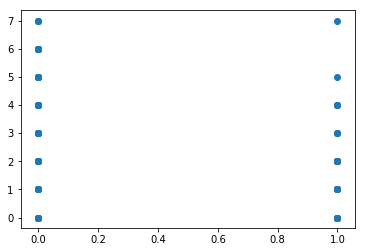

In [140]:
import matplotlib.pyplot as plt

plt.scatter(x=names_to_consider['gender_dif'], y=names_to_consider['score_2'])

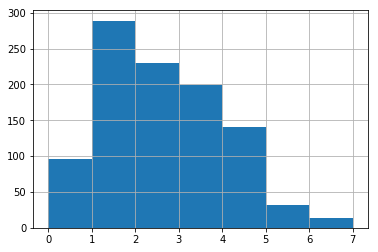

In [141]:
names_to_consider['score_2'].hist(bins=7)

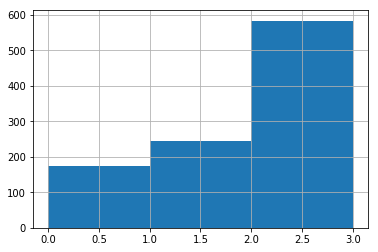

In [142]:
names_to_consider['score'].hist(bins=3)

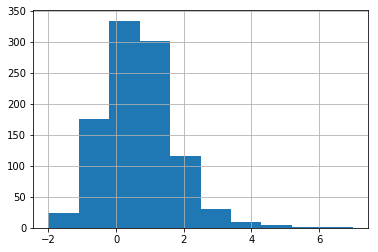

In [143]:
names_to_consider['score_dif'].hist()

In [144]:
names_by_score_dif = names_to_consider.groupby(['score_dif', 'gender_dif'])

In [145]:
names_by_score_dif = names_by_score_dif.agg({'score':'count'}) # score just counts how many entries there are per score_dif and gender_dif

In [146]:
score_diffs = list(map(lambda x: x[0], names_by_score_dif.index.values))
gender_diffs = list(map(lambda x: x[1], names_by_score_dif.index.values))

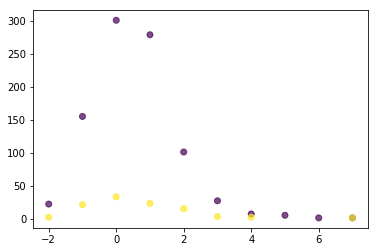

In [147]:
plt.scatter(x=score_diffs, y=names_by_score_dif['score'], c=gender_diffs, alpha=0.7)

In [148]:
descriptive_statistics_improved_names_sample1 = names_to_consider.describe()
descriptive_statistics_improved_names_sample1

,n_publs,score,score_2,score_dif
count,1000.000000,1000.00000,999.000000,999.000000
mean,6.322000,1.67000,2.150150,0.481481
std,25.759734,1.04508,1.394765,1.217527
min,1.000000,0.00000,0.000000,-2.000000
25%,1.000000,1.00000,1.000000,0.000000
50%,1.000000,2.00000,2.000000,0.000000
75%,3.000000,3.00000,3.000000,1.000000
max,518.000000,3.00000,7.000000,7.000000


In [149]:
print("Saving test names...")
descriptive_statistics_improved_names_sample1.to_csv("data/names_improvement_test_statistics.csv")
print("Test names saved!")

Saving test names...
Test names saved!


In [159]:
gender_changed = names_to_consider[names_to_consider['gender_dif'] == True]

In [160]:
gender_changed.describe()

,n_publs,score,score_2,score_dif
count,100.000000,100.000000,100.000000,100.000000
mean,6.500000,0.470000,0.990000,0.520000
std,18.450315,0.717107,1.210184,1.396098
min,1.000000,0.000000,0.000000,-2.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,0.000000
75%,4.250000,1.000000,1.000000,1.000000
max,167.000000,3.000000,7.000000,7.000000


In [161]:
gender_changed_more_certain = gender_changed[gender_changed['score_dif'] > 0]

In [162]:
gender_changed_more_certain.describe()

,n_publs,score,score_2,score_dif
count,44.000000,44.000000,44.000000,44.000000
mean,6.568182,0.136364,1.886364,1.750000
std,11.694558,0.509943,1.279824,1.143739
min,1.000000,0.000000,1.000000,1.000000
25%,1.000000,0.000000,1.000000,1.000000
50%,2.000000,0.000000,1.500000,1.000000
75%,6.250000,0.000000,2.000000,2.000000
max,63.000000,3.000000,7.000000,7.000000


In [153]:
score_improved = names_to_consider[names_to_consider['score_dif'] > 0]

In [154]:
score_improved.describe()

,n_publs,score,score_2,score_dif
count,465.000000,465.000000,465.000000,465.000000
mean,7.079570,1.531183,3.047312,1.516129
std,33.121383,1.140740,1.297344,0.893136
min,1.000000,0.000000,1.000000,1.000000
25%,1.000000,0.000000,2.000000,1.000000
50%,2.000000,2.000000,3.000000,1.000000
75%,4.000000,3.000000,4.000000,2.000000
max,518.000000,3.000000,7.000000,7.000000


In [ ]:
# The gender assumption changed for only 100 of 1000 entries 
# (assuming the gender change is valid if the new score is higher than the old score, which is the case in 44 cases)

# The score improves on average by 0.48 with a std of 1.21. 
# The mean improvement is 0, the 25% quartile is 0, the 75% quartile is 1.
# The score is at maximum improved by 7 and in the worst case decreased by 2.